![example](images/director_shot.jpeg)

# Exploratory Analysis of Movies Released from 1915 and 2018

**Authors:** Chi Bui
***

## Overview

The objective of this project is to use exploratory data analysis and visualization to identify current trends and key parameters of a successful movie. Using data science, we can potentially predict customer preference and determine how to construct and optimize content for our product to reach its maximum potential.


## Business Problem

The filmmaking industry is currently dominated by 6 big players <b>'Warner Bros'</b>, <b>'Walt Disney'</b>, <b>'20th Century Fox'</b>, <b>'Paramount'</b>, <b>'Sony'</b>, and <b>'Universal'</b>,  which account for approximately 80% of the market share altogether. Planning for a debut into a highly competitive market for a new company would therefore require thorough analysis of the current landscape of the film industry. 

The objective of this project is to use ***exploratory data analysis*** and ***visualization*** to investigate the relations between certain attributes like **genres**, **directors**, **production company**, **month of release** on a movie’s commercial success, as well as the correlation between **ratings** and **box office gross**. Our goal is to use data collected from two main sources [**Rotten Tomatoes**](https://www.rottentomatoes.com/) and [**thenumber.org**](https://www.the-numbers.com/market/) to study market trends from 1915 to 2018 with a special focus on the 2000-2018 to derive insights on how to optimize a debut into the movie industry for a new company in 2021.

## Data Understanding

We are provided with 11 movie datasets from various sources:
- [Box Office Mojo](https://www.boxofficemojo.com/) (1)
- [IMDb](https://www.imdb.com/) (6)
- [Rotten Tomatoes](https://www.rottentomatoes.com/) (2)
- [The Movie Database](https://www.themoviedb.org/) (1)
- [The Numbers](https://www.the-numbers.com/market/) (1)

The final dataframe used for the majority of analyses this project (`tn_rotten_tomatoes`) is a merge between datasets from <b>the-numbers.com</b> and <b>Rotten Tomatoes</b>. This dataset contains 4348 entries for movies released in the span of 104 years from 1915-02-08 to 2018-12-31.

The goal of this project is to weigh the impacts of attributes like genres, directors, production company, and month of release on the commercial success of movies as well as the correlation between ratings and worldwide gross. More specifically, commercial success of movies are evaluated based on:
- <b>box office gross</b>
- <b>profit</b> = worldwide gross - production budget 
- <b>rate of return</b> = profit / production budget

Both ways of assessing commercial success would be added to our dataset as individual columns (`profit` and `rate_of_return`). Datatype for both is `float` for easy manipulation and calculation of the data. 

We will go through each of these attributes (i.e., `genres`, `directors`, `production_compay`, and `release_date`) and analyze the relation between each of them and `profit` and/or `rate_of_return`.

## Data Importing

In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns
import helpers

%matplotlib inline

In [2]:
files, filenames = helpers.import_files()

In [3]:
# Read csv files as pandas dataframes
dfs = {fn: pd.read_csv(f) for (fn, f) in zip(filenames, files)}

## Data Preparation

### Dataset Selection

In [4]:
dfs['tn_movie_budgets'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [5]:
dfs['bom_movie_gross'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


Among the 11 datasets provided, only 2 contains Box Office information, which are `tn_movie_budget` and `bom_movie_gross`.

`tn_movie_budget` has 5782 entries spanning 106 years from 1915 to 2020, none of which is yet identified as `NaN` value. On the other hand, `bom_movie_gross` has 3387 entries from 2015 to 2018; 28 out of 3387 entries have a `NaN` value for `domestic_gross` column, and 1350 have a `NaN` value for `foreign_gross`. 

Between the 2 datasets, `tn_movie_budget` seems to be a better choice for Box Office success analysis. However, currently the datatypes of `production_budget`, `domestic_gross` and `worldwide_gross` of `tn_movie_budget` are all `object`. They also contain the non-numerical characters, such as US Dollar (`$`) and commas (`,`), which would need to be removed and converted back to `float` for further data analysis. 

### Dataset Cleaning & Feature Engineering

In [6]:
# Clean data in the 'production_budget', 'domestic_gross' & 'worldwide_gross' columns of `tn_movie_budgets`
 
dfs['tn_movie_budgets'].production_budget = dfs['tn_movie_budgets'].production_budget.map(lambda x: helpers.remove_non_digit_chars(x))
dfs['tn_movie_budgets'].worldwide_gross = dfs['tn_movie_budgets'].worldwide_gross.map(lambda x: helpers.remove_non_digit_chars(x))
dfs['tn_movie_budgets'].domestic_gross = dfs['tn_movie_budgets'].domestic_gross.map(lambda x: helpers.remove_non_digit_chars(x))

And then we will add 2 more columns to `dfs['tn_movie_budgets']`:
- <b>Profit</b> (`profit`) = `worldwide_gross` - `production_budget`
- <b>Rate of Return</b>(`rate_of_return`) = `profit` / `production_budget`

In [7]:
dfs['tn_movie_budgets']['profit'] = dfs['tn_movie_budgets'].worldwide_gross - dfs['tn_movie_budgets'].production_budget
dfs['tn_movie_budgets']['rate_of_return'] = dfs['tn_movie_budgets'].profit / dfs['tn_movie_budgets'].production_budget

Since one of the attributes we would be focusing on is <b>month of release</b>, we will extract this information out from `release_date` in `tn_movie_budget` and store it in its own column called `release_month`.

In [8]:
# Add 'release_month' to 'tn_movie_budget' 
dfs['tn_movie_budgets']['release_month'] = dfs['tn_movie_budgets'].release_date.map(lambda x: x.split()[0])

In [9]:
# Convert release_date column to datetime object for easy manipulation of the date later
dfs['tn_movie_budgets'].release_date = pd.to_datetime(dfs['tn_movie_budgets'].release_date)

### Dataset Merging

In order to investigate the relations between <b>genres</b>, <b>directors</b>, <b>month of release</b>, <b>production company</b> with financial data (<b>worldwide gross</b>, <b>profit</b>, and <b>rate of return</b>), we will need to select appropriate datasets for information on the formerly mentioned features.  

Among 11 provided datasets, only `tmdb_movies`, `rotten_tomatoes_movies` and `imdb_title_basics` contain genres information:
- `tmdb_movies` has an `genre_ids` column, in which genres are stored as a list of `genre_id`. For example, the genres for <b>"Avengers: Infinity War"</b> is defined as  `[12, 28, 14]`. This type of data storage would have been useful if we have access to another table containing id code(s) and name of genre(s) for tmdb. 
- `imdb_title_basics` and `rotten_tomatoes_movies` both have a `genres` column, which holds information in the form of a string with genres separated by commas. For example, the genres for <b>"Avengers: Infinity War"</b> is categorized as `"Action & Adventure, Science Fiction & Fantasy"` in `rotten_tomatoes_movies` and as `"Action,Adventure,Sci-Fi"` in `imdb_title_basics`. `imdb_title_basics` has 146144 entries, and `rotten_tomatoes_movies` has 17712.

Since there is currently no dataset containing both box office and genre information, we will proceed to merge `tn_movie_budgets` with both `imdb_title_basics` and `rotten_tomatoes_movies` to see which option generates the most amount of usable data.

In [10]:
# Merging dfs['tn_movie_budgets'] and dfs['rotten_tomatoes_movies']
tn_rotten_tomatoes = dfs['tn_movie_budgets'].merge(dfs['rotten_tomatoes_movies'], 
                                                   how='inner', 
                                                   left_on='movie', right_on='movie_title')
tn_rotten_tomatoes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4776 entries, 0 to 4775
Data columns (total 31 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id                                4776 non-null   int64         
 1   release_date                      4776 non-null   datetime64[ns]
 2   movie                             4776 non-null   object        
 3   production_budget                 4776 non-null   float64       
 4   domestic_gross                    4776 non-null   float64       
 5   worldwide_gross                   4776 non-null   float64       
 6   profit                            4776 non-null   float64       
 7   rate_of_return                    4776 non-null   float64       
 8   release_month                     4776 non-null   object        
 9   rotten_tomatoes_link              4776 non-null   object        
 10  movie_title                       4776 non-null 

In [11]:
# Merging dfs['tn_movie_budgets'] and dfs['imdb_title_basics']
tn_imdb = dfs['tn_movie_budgets'].merge(dfs['imdb_title_basics'], 
                                        how='inner', 
                                        left_on='movie', right_on='primary_title')\
                                 .drop('movie', axis=1)
tn_imdb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3815 entries, 0 to 3814
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 3815 non-null   int64         
 1   release_date       3815 non-null   datetime64[ns]
 2   production_budget  3815 non-null   float64       
 3   domestic_gross     3815 non-null   float64       
 4   worldwide_gross    3815 non-null   float64       
 5   profit             3815 non-null   float64       
 6   rate_of_return     3815 non-null   float64       
 7   release_month      3815 non-null   object        
 8   tconst             3815 non-null   object        
 9   primary_title      3815 non-null   object        
 10  original_title     3814 non-null   object        
 11  start_year         3815 non-null   int64         
 12  runtime_minutes    3328 non-null   float64       
 13  genres             3743 non-null   object        
dtypes: datet

Merging `tn_movie_budgets` and `rotten_tomatoes_movies` retains 4776 entries, which is 25% higher than merging `tn_movie_budgets` with `imdb_title_basics`, therefore, we will proceed forwards with our new `tn_rotten_tomatoes` dataframe. 

In order to focus on the data relevant to our analysis, we will drop column with duplicated information, such as `movie` which is essentially the same as `movie_title`. Similarly, we will drop rows with duplicated information based on 2 columns `movie_title` and `release_date`.

In [12]:
tn_rotten_tomatoes.drop('movie', axis=1, inplace=True)

In [13]:
tn_rotten_tomatoes.drop_duplicates(['movie_title', 'release_date'], keep='last', inplace=True)

In [14]:
# Removing all datapoints for 2019:
tn_rotten_tomatoes = tn_rotten_tomatoes[~(tn_rotten_tomatoes.release_date.dt.year == 2019)]

In [15]:
tn_rotten_tomatoes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4304 entries, 0 to 4775
Data columns (total 30 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id                                4304 non-null   int64         
 1   release_date                      4304 non-null   datetime64[ns]
 2   production_budget                 4304 non-null   float64       
 3   domestic_gross                    4304 non-null   float64       
 4   worldwide_gross                   4304 non-null   float64       
 5   profit                            4304 non-null   float64       
 6   rate_of_return                    4304 non-null   float64       
 7   release_month                     4304 non-null   object        
 8   rotten_tomatoes_link              4304 non-null   object        
 9   movie_title                       4304 non-null   object        
 10  movie_info                        4279 non-null 

<u>Notes</u>: 
- By mergining `tn_movie_budgets` with `rotten_tomatoes_movies`, we lost 3 entries for 2020. 
- Upon further investigation of the dataset, there are only 44 entries recorded for 2019, which is highly complete. Including data for 2019 hence would not reflect the trends of the filmmaking industry fairly. We've decided to remove these 44 entries altogether for this reason.

Final version of the `tn_rotten_tomatoes` DataFrame that we will be working with contains 4304 entries for movies released in the span of 104 years from 1915-02-08 to 2018-12-31.

## Analysis

### Movie Industry Overview
We will start off with some general overview of the movie production industry from 1915 to 2018, with more focus on the most recent period (2000-2018).

#### Number of Movies Released Each Year (1915-2018)

In [16]:
movie_count_total_1Y = tn_rotten_tomatoes.groupby(tn_rotten_tomatoes.release_date.dt.year)\
                                         .movie_title.nunique()

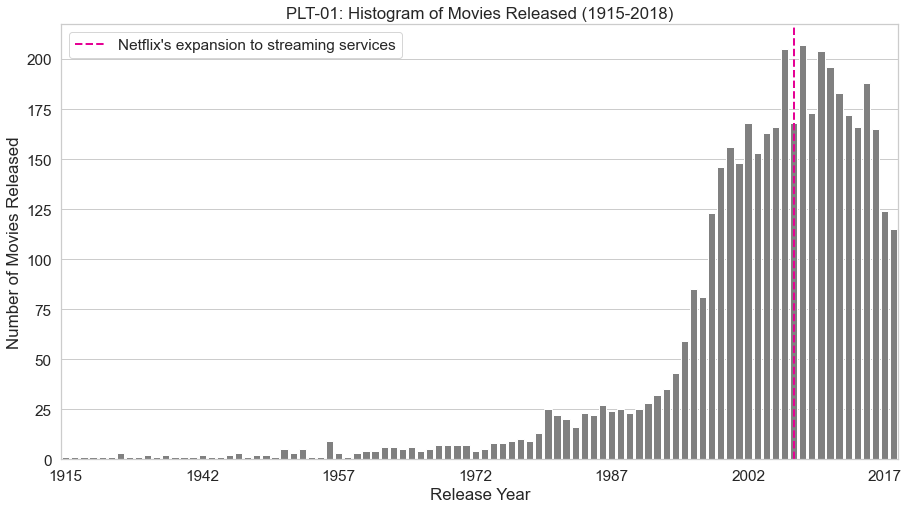

In [17]:
# Histogram showing number of movies released each year 1915-2019
sns.set(style="whitegrid",
        font_scale=1.4)
fig, ax = plt.subplots(figsize=(15, 8))
ax = sns.barplot(x=movie_count_total_1Y.index,
                 y=movie_count_total_1Y,
                 color='gray')
ax.set(xlabel='Release Year', 
       ylabel='Number of Movies Released',
       title='PLT-01: Histogram of Movies Released (1915-2018)')

ax.xaxis.set_major_locator(plticker.MultipleLocator(15))

plt.axvline(x=80, color='#e50194', linestyle='--', linewidth=2,
            label="Netflix's expansion to streaming services")

plt.legend()
plt.show();

At first glance, it might seem like the movie production industry hit its latest peak in 2008 with 207 movies recorded in our dataset. And then in 2018, there are only 115 entries, which is roughly 55% that of 2008.

Further investigation on the dataset shows that `tn_movie_budgets` does <b>NOT</b> include many datapoints for movies released straight to streaming services, which mostly have a value of 0 for both `worldwide_gross` an `domestic_gross` in our dataset. Although traditionally, one of the most popular "parameters" of success for a movie is Box Office, rapid development of technology as well as the growth of media streaming platforms have made it significantly easier for people to watch movies and T.V. shows at their convenience in their own homes. Instead of spending close to USD 10 on a ticket to see 1 movie at a movie theater, more people have opted for streaming subscription(s) of USD 8-20/month to have access to thousands of movies and T.V. shows. Netflix was originally founded in 1997, and began offering streaming services to its subscribers in 2007, which coincides with the peak of box office in 2008. From this first plot (PLT-01), we can see how streaming media have quickly taken over movie theaters in the span of only 10 years. 

A key determinant for box office success is the number of screens where the movie is released; and this plot shows the importance of how and by whom a movie should be distributed to maximize audience access and user engagement going forward. 

In [18]:
movie_revenue_total_1Y = tn_rotten_tomatoes.groupby(tn_rotten_tomatoes.release_date.dt.year)\
                                           .worldwide_gross.sum()\
                                           .reset_index()

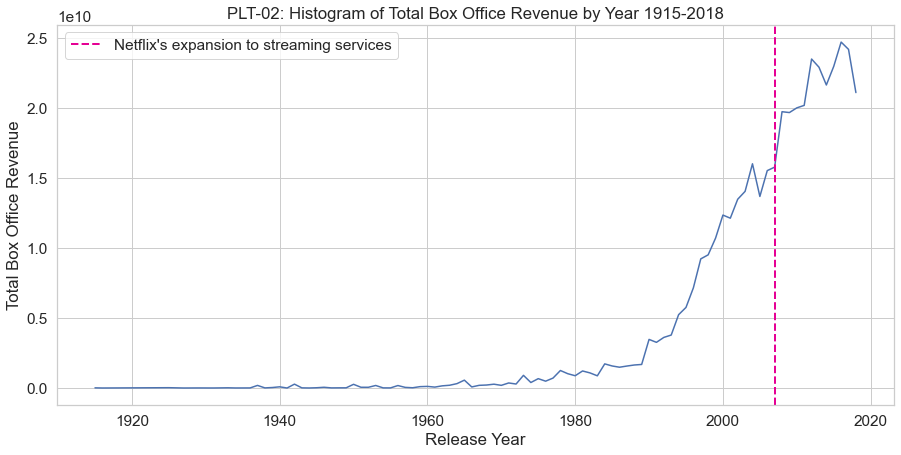

In [19]:
# Histogram showing total box office revenue by year 1915-2019
sns.set(style="whitegrid",
        font_scale=1.4)
fig, ax = plt.subplots(figsize=(15, 7))
ax = sns.lineplot(data=movie_revenue_total_1Y,
                  x="release_date",
                  y="worldwide_gross")
ax.set(xlabel='Release Year', 
       ylabel='Total Box Office Revenue',
       title='PLT-02: Histogram of Total Box Office Revenue by Year 1915-2018')

ax.xaxis.set_major_locator(plticker.MultipleLocator(20))

plt.axvline(x=2007, color='#e50194', linestyle='--', linewidth=2,
            label="Netflix's expansion to streaming services")

plt.legend()
plt.show();

From plot PLT-02, we can see that total box office revenue is still on the rise after 2007.

#### Top Grossing Movie Each Year (2000-2018)

In [20]:
tn_rotten_tomatoes_0019 = tn_rotten_tomatoes[tn_rotten_tomatoes.release_date.isin(pd.date_range('2000-01-01', '2019-12-31'))]
max_gross_ids = tn_rotten_tomatoes_0019.groupby(tn_rotten_tomatoes.release_date.dt.year)\
                            .worldwide_gross.idxmax()
max_gross_0019 = tn_rotten_tomatoes.loc[max_gross_ids]\
                    [['release_date', 'movie_title', 'production_budget', 'worldwide_gross', 'production_company']]\
                    .sort_values('release_date', ascending=False)               

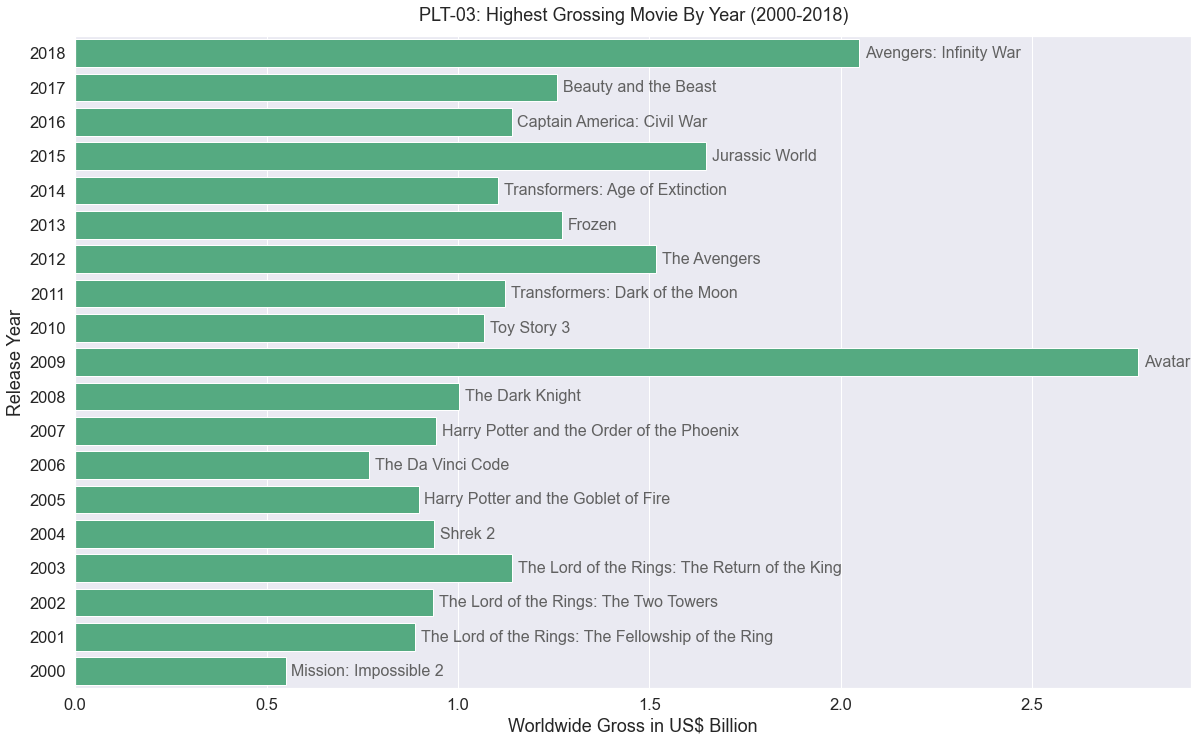

In [21]:
# Bar Plot - Max Gross Movie 2000-2019
sns.set(style="darkgrid",
        font_scale=1.5)

fig, ax = plt.subplots(figsize=(20, 12))
ax = sns.barplot(x=max_gross_0019.worldwide_gross, 
                 y=max_gross_0019.release_date.dt.year.astype(str),
                 color='#47b881')
ax.set(xlabel='Worldwide Gross in US$ Billion', 
       ylabel='Release Year')
ax.set_title('PLT-03: Highest Grossing Movie By Year (2000-2018)', pad=15)

ax.xaxis.set_major_formatter(plticker.FuncFormatter(lambda x, pos: '{:,.1f}'.format(x/(10**9))))

for i in range(len(max_gross_0019)):
    ax.text(max_gross_0019.iloc[i].worldwide_gross + 1.5*10**7, i,
            max_gross_0019.iloc[i].movie_title,
            verticalalignment='center',
            fontsize=16,
            color='#616161')

plt.show();

#### Top Movies with Highest Rate of Return (2000-2018)

In [22]:
# Top 200 movies with highest 'rate_of_return' (2000-2018)
top200returns = tn_rotten_tomatoes[tn_rotten_tomatoes.release_date.isin(pd.date_range('2000-01-01', '2018-12-31'))]\
                        .sort_values(by=['rate_of_return'], ascending=False)[:200]\
                        [['movie_title', 'release_date', 'release_month', 'rate_of_return', 'genres']]

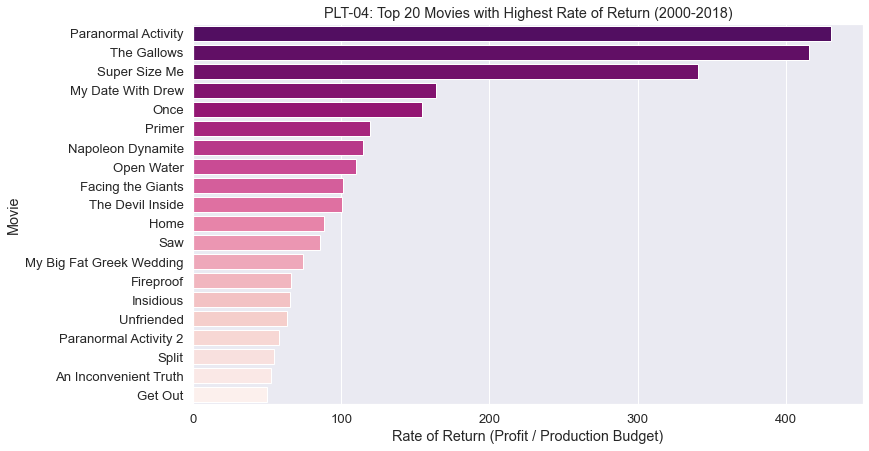

In [23]:
# Bar Plot - top 20 movies with highest 'rate_of_return' since 2000
sns.set(style='darkgrid', font_scale=1.2)
fig, ax = plt.subplots(figsize=(12, 7))
ax = sns.barplot(x=top200returns[:20].rate_of_return, 
                 y=top200returns[:20].movie_title,
                 palette='RdPu_r')
ax.set(xlabel='Rate of Return (Profit / Production Budget)',
       ylabel='Movie', 
       title='PLT-04: Top 20 Movies with Highest Rate of Return (2000-2018)')
plt.show();

Taking a quick look at plot PLT-03, we can see that a number of these top 20 movies with highest rate of return between 2000 and 2018 can be categorized as <b>Horror</b> and/or <b>Mystery & Suspense</b>. We will return to this at a later point of our analysis.

### Feature Analysis
Next, we will start investigating the roles of more specific features of movies.

#### 1. Genres
First, we will identify 20 most successful genres/genre combinations in the `tn_rotten_tomatoes` DataFrame in terms of sales.

Commercial success of genres would be evaluated in 3 different ways:
- Total profit generated
- Average profit per movie
- Average rate of return

In [24]:
# (1) - Total Profit Generated
top20genres_sumprofit = tn_rotten_tomatoes.groupby(by='genres').profit.sum().sort_values(ascending=False)[:20]

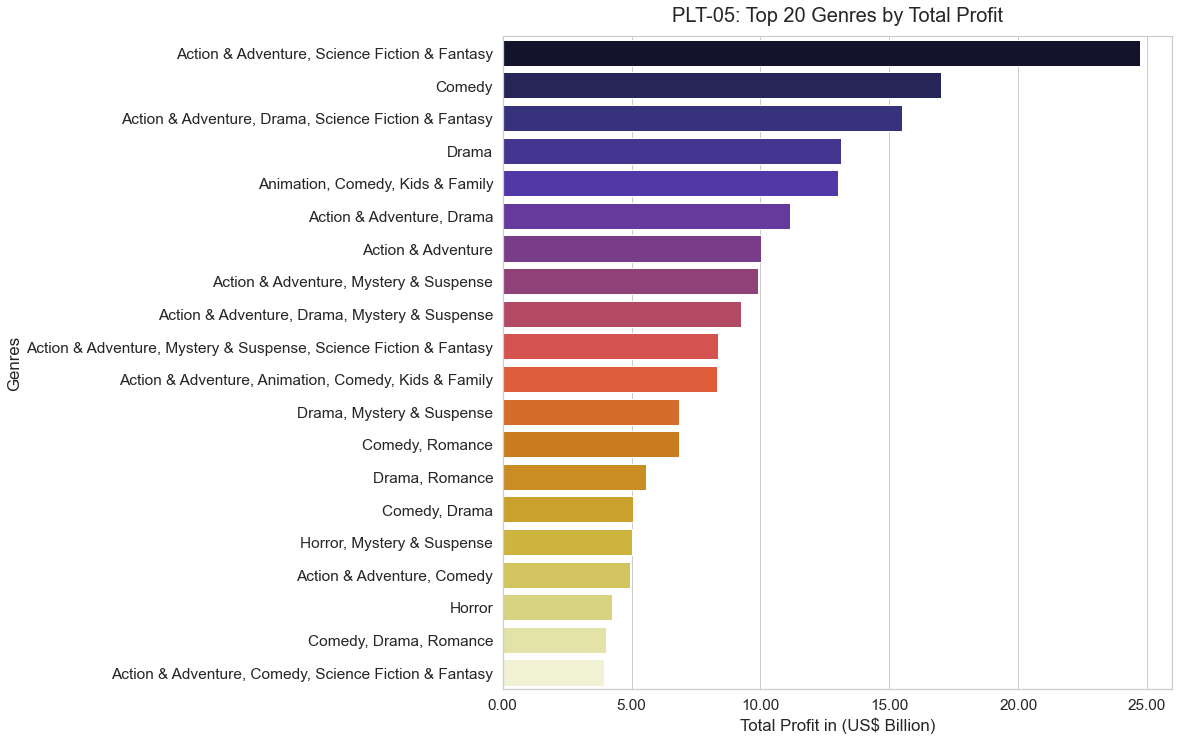

In [25]:
# Bar Plot - Top 20 Genres by Total Profit
sns.set(style="whitegrid",
        font_scale=1.4)
fig, ax = plt.subplots(figsize=(12, 12))
ax = sns.barplot(x=top20genres_sumprofit, 
                 y=top20genres_sumprofit.index,
                 palette='CMRmap')
ax.set(xlabel='Total Profit in (US$ Billion)', 
       ylabel='Genres')
ax.set_title('PLT-05: Top 20 Genres by Total Profit', pad=15, fontsize=20)

ax.xaxis.set_major_formatter(plticker.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x/(10**9))))

plt.show();

In [26]:
# (2) - Average Profit per Movie
top20genres_avgprofit = tn_rotten_tomatoes.groupby(by='genres').profit.mean().sort_values(ascending=False)[:20]

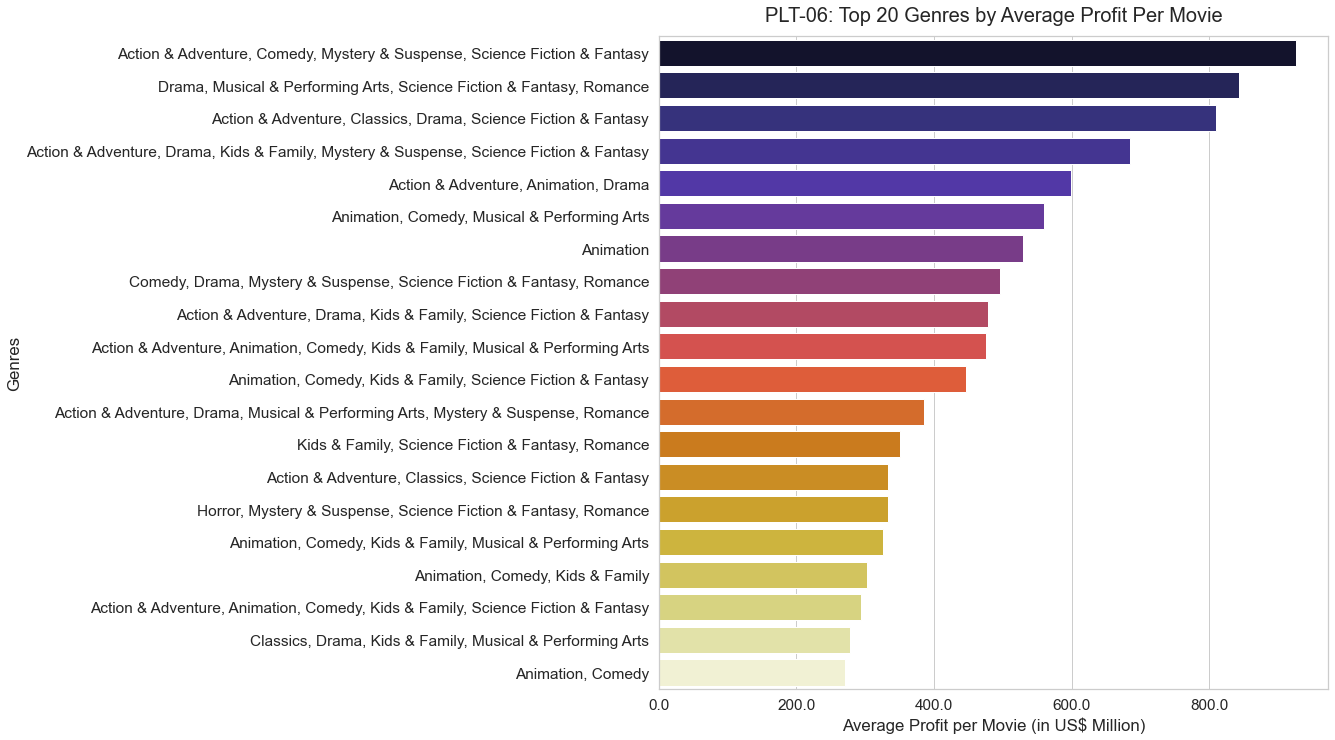

In [27]:
# Bar Plot - Top 20 Genres by Average Profit per Movie
sns.set(style="whitegrid",
        font_scale=1.4)
fig, ax = plt.subplots(figsize=(12, 12))
ax = sns.barplot(x=top20genres_avgprofit, 
                 y=top20genres_avgprofit.index,
                 palette='CMRmap')
ax.set(xlabel='Average Profit per Movie (in US$ Million)', 
       ylabel='Genres')
ax.set_title('PLT-06: Top 20 Genres by Average Profit Per Movie', pad=15, fontsize=20)

ax.xaxis.set_major_formatter(plticker.FuncFormatter(lambda x, pos: '{:,.1f}'.format(x/(10**6))))

plt.show();

In [28]:
# (1) - Average Rate of Return
top20genres_avgror = tn_rotten_tomatoes.groupby(by='genres').rate_of_return.mean().sort_values(ascending=False)[:20]

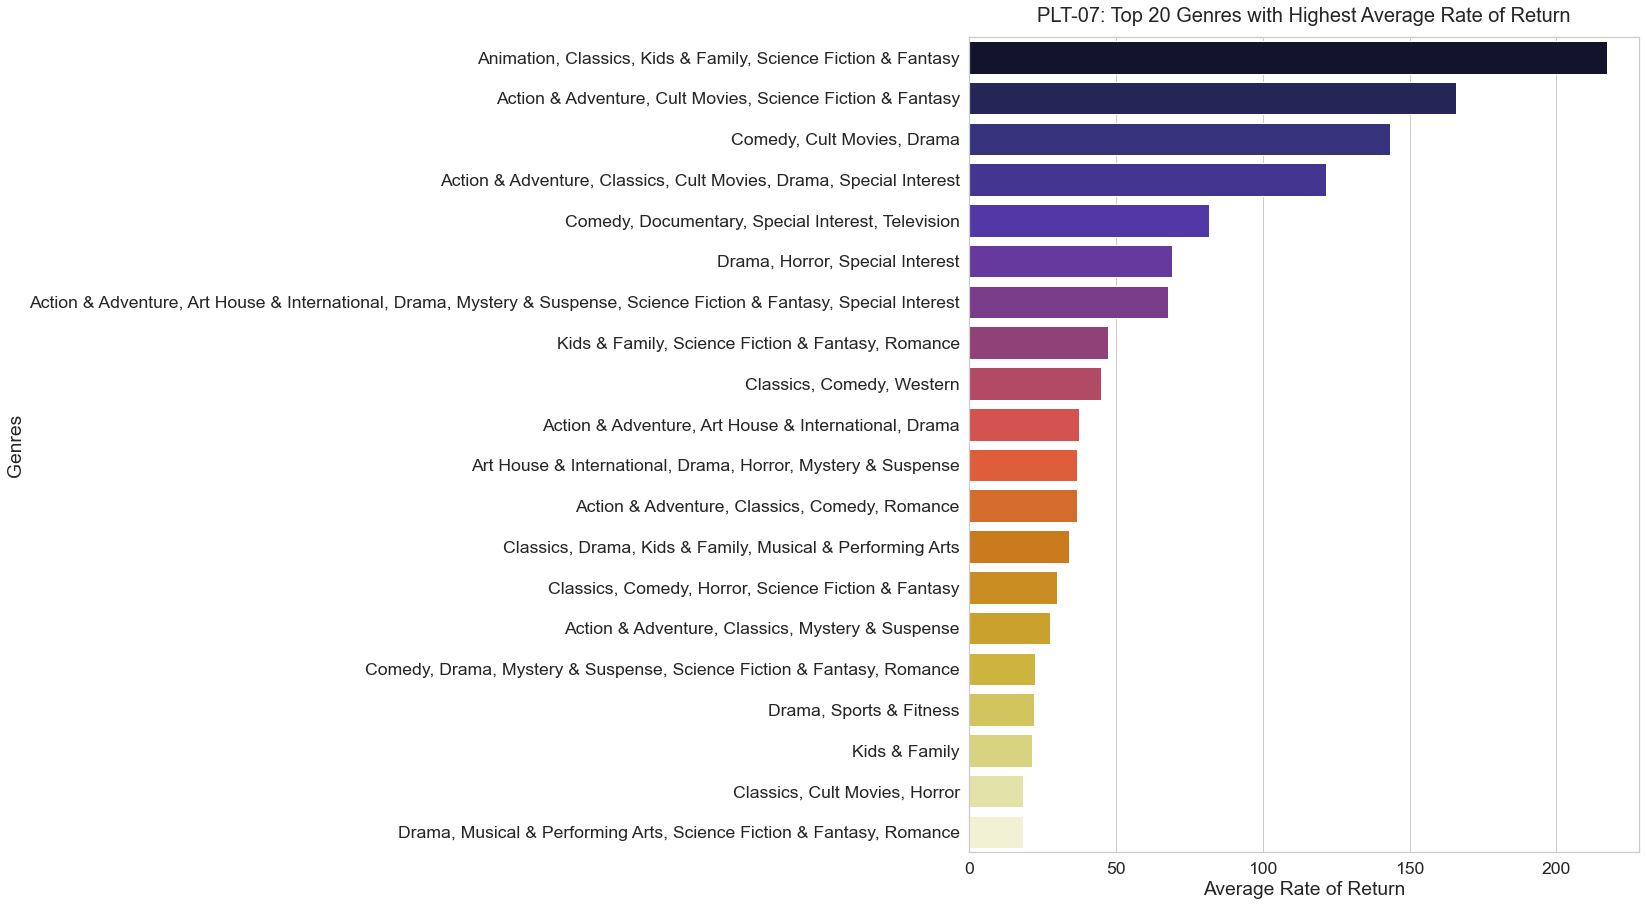

In [29]:
# Bar Plot - Top 20 Genres with Highest Average Rate of Return
sns.set(style="whitegrid",
        font_scale=1.6)
fig, ax = plt.subplots(figsize=(12, 15))
ax = sns.barplot(x=top20genres_avgror, 
                 y=top20genres_avgror.index,
                 palette='CMRmap')
ax.set(xlabel='Average Rate of Return', 
       ylabel='Genres')
ax.set_title('PLT-07: Top 20 Genres with Highest Average Rate of Return', pad=15, fontsize=20)

plt.show();

All 3 plots (PLT-05, PLT-06, PLT-07) seem to indicate that movies with high commercial success are rarely categorized solely as one single genre. 

The 4 genres <b>Action & Adventure</b>, <b>Science Fiction & Fantasy</b>, <b>Comedy</b>, and <b>Drama</b> consistently appear in all 3 plots, which provides some insights in terms of which combination(s) of genres/contents might be worth investing in for high return. Combining genres usually help attract different audience and bring in more demographics within the context of each individual film. This initial exploration on genre indicates that a combination of <b>Action & Adventure</b> and <b>Science Fiction & Fantasy</b> with some <b>Comedy</b> and <b>Drama</b> elements tend to do relatively well. 

Next, we can dive deeper into the analysis of individual genres by splitting the `genres` value for each row into separate rows, each of which only contains a single genre. For example, one entry for <b>"Avengers: Infinity War"</b> with `"Action & Adventure, "Science Fiction & Fantasy"` will be split into 2 different rows, one with only `"Action & Adventure"` and the other with just `"Science Fiction & Fantasy"`.

In [30]:
tn_rottentomatoes = helpers.split_column(tn_rotten_tomatoes, 'genres')

In [31]:
print(len(tn_rottentomatoes.genres.unique()))
tn_rottentomatoes.genres.unique()

20


array(['Action & Adventure', 'Comedy', 'Mystery & Suspense',
       'Science Fiction & Fantasy', 'Drama', 'Kids & Family', 'Western',
       'Horror', 'Animation', 'Musical & Performing Arts', 'Romance',
       'Sports & Fitness', 'Classics', 'Art House & International',
       'Cult Movies', 'Television', 'Documentary', 'Special Interest',
       'Faith & Spirituality', 'Gay & Lesbian'], dtype=object)

Our dataset contains 20 individual genres. We will then analyze the success of each genre by plotting their average profit per film tagged with that genre from 1915 to 2019. 

In [32]:
mean_profit_genres = tn_rottentomatoes.groupby(by='genres').profit.mean().sort_values(ascending=False)

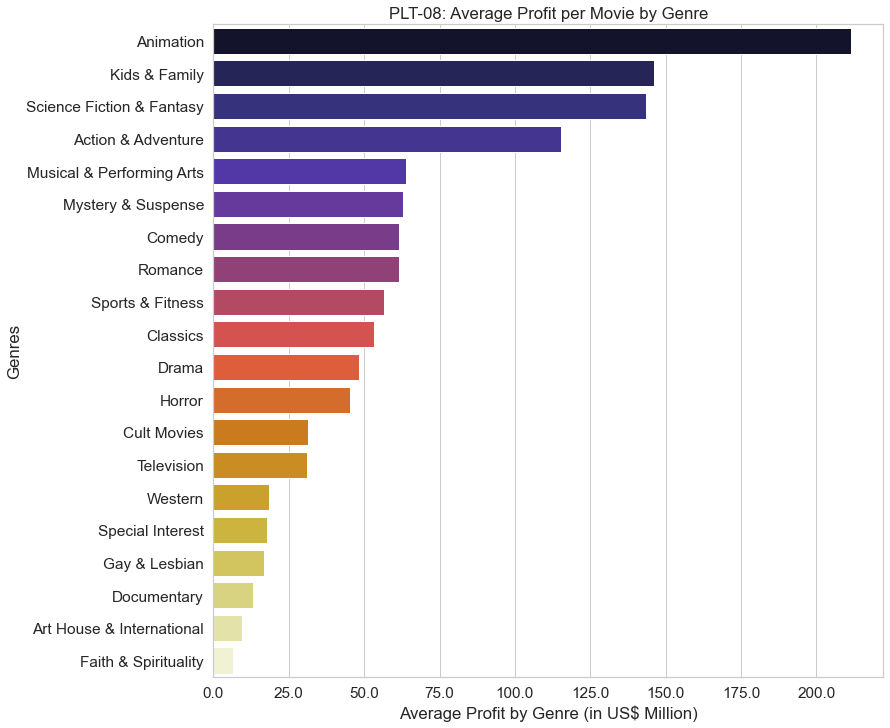

In [33]:
# Bar Plot - Average profit for different genres
sns.set(style="whitegrid",
        font_scale=1.4)
fig, ax = plt.subplots(figsize=(12, 12))
ax = sns.barplot(x=mean_profit_genres, 
                 y=mean_profit_genres.index,
                 palette='CMRmap')
ax.set(xlabel='Average Profit by Genre (in US$ Million)', 
       ylabel='Genres',
       title='PLT-08: Average Profit per Movie by Genre')

ax.xaxis.set_major_formatter(plticker.FuncFormatter(lambda x, pos: '{:,.1f}'.format(x/(10**6))))

plt.show();

Some factors that might have contributed to <b>Animation</b>'s high success:

- <b>Animation</b> are no longer made mostly for the younger audience. 

- Children are usually accompanied by adults at movie theaters.

- <b>Animation</b>s often times are based on books/stories, which usually have well-established fan base.

We will then track the number of movies for each genre from 1915 to 2018, which might demonstrate how trends during this period.

In [34]:
movie_count_genres_5Y = tn_rottentomatoes.set_index('release_date')\
                        .groupby([pd.Grouper(freq='5Y'), 'genres'])\
                        .movie_title.nunique()\
                        .reset_index()

In [35]:
tn_rottentomatoes.groupby('genres').movie_title.count().sort_values(ascending=False)

genres
Drama                        2268
Comedy                       1588
Action & Adventure           1304
Mystery & Suspense           1021
Science Fiction & Fantasy     677
Romance                       488
Horror                        488
Kids & Family                 389
Animation                     205
Art House & International     193
Classics                      174
Musical & Performing Arts     163
Special Interest              106
Documentary                   104
Western                        64
Sports & Fitness               35
Cult Movies                    20
Faith & Spirituality           20
Television                     18
Gay & Lesbian                   9
Name: movie_title, dtype: int64

In [36]:
top5genres = tn_rottentomatoes.groupby('genres').movie_title.count().sort_values(ascending=False)[:5]
top5genres.index

Index(['Drama', 'Comedy', 'Action & Adventure', 'Mystery & Suspense',
       'Science Fiction & Fantasy'],
      dtype='object', name='genres')

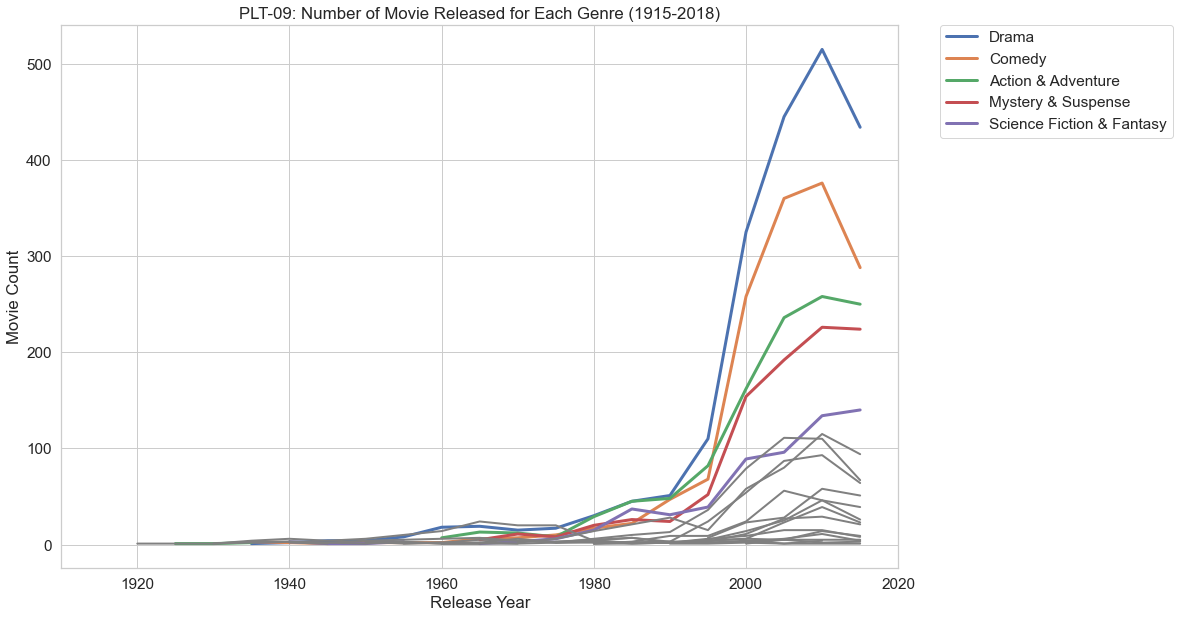

In [37]:
# Movie Count tracking for the each genre every 5 year period
dt = movie_count_genres_5Y.set_index(movie_count_genres_5Y.release_date.dt.year)\
                          .pivot(columns='genres', values='movie_title').iloc[:-1]
dt_colored = dt[top5genres.index]
dt_gray = dt[[x for x in dt.columns if x not in (top5genres.index)]]

fig, ax = plt.subplots(figsize=(15,10))
ax.plot(dt_colored, lw=3)
ax.plot(dt_gray, lw=2, color='gray')
ax.set(xlabel = 'Release Year',
       ylabel = 'Movie Count',
       title = 'PLT-09: Number of Movie Released for Each Genre (1915-2018)')
ax.xaxis.set_major_locator(plticker.MultipleLocator(20))
plt.legend(top5genres.index, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show();

From the plot PLT-08 above, the top 5 genres in terms of movie count since 1990s have been <b>Drama</b>, <b>Comedy</b>, <b>Action & Adventure</b>, <b>Mystery & Suspense</b>, <b>Science Fiction & Fantasy</b>.

In order to identify the most recent information on the latest trends, we will zoom in 2000-2018 to see how the genre distributions of movies released in theaters has changed over the more recent years.

In [38]:
movie_count_genres_0018 = tn_rottentomatoes[tn_rottentomatoes.release_date.isin(pd.date_range('2000-01-01', '2018-12-31'))]\
                            .set_index('release_date')\
                            .groupby([pd.Grouper(freq='1Y'), 'genres'])\
                            .movie_title.nunique()\
                            .reset_index()

We will then add a `percentage` column to `movie_count_genres_0018` representing the percentage all films released each year with the corresponding genre tagged.

In [39]:
movie_count_genres_0018['percentage'] = 100 * movie_count_genres_0018.movie_title / movie_count_genres_0018.groupby('release_date').movie_title.transform('sum')

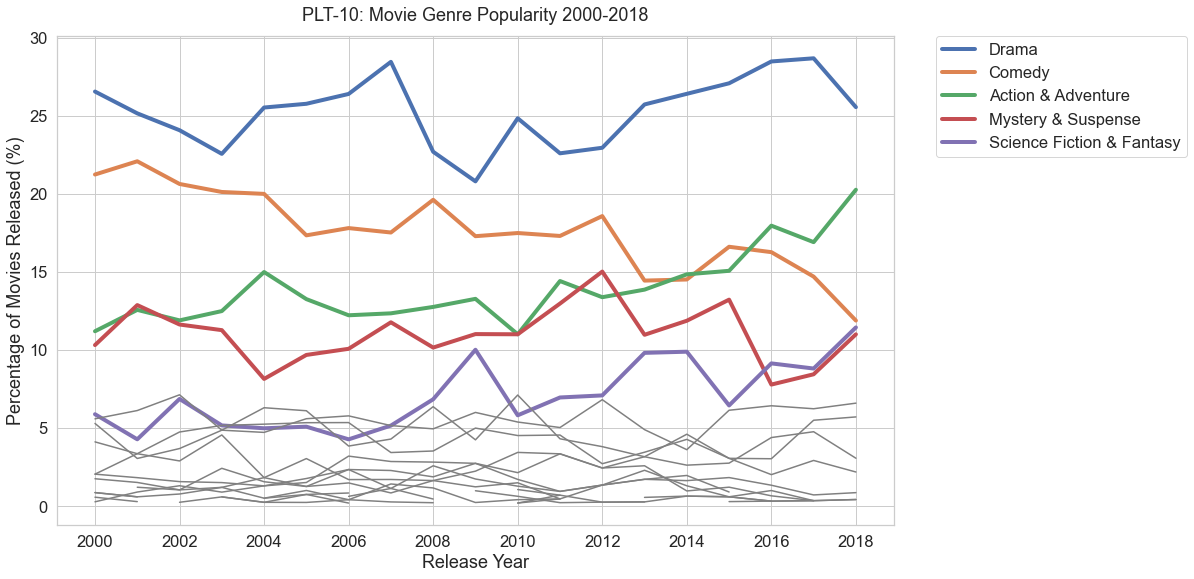

In [40]:
# Movie Genre Popularity (2000-2018)
sns.set_palette('Paired')
sns.set(style='whitegrid', font_scale=1.5)
dt = movie_count_genres_0018.set_index(movie_count_genres_0018.release_date.dt.year)\
                            .pivot(columns='genres', values='percentage')
dt_colored = dt[top5genres.index]
dt_gray = dt[[x for x in dt.columns if x not in (top5genres.index)]]
fig, ax = plt.subplots(figsize=(15,9))

ax.plot(dt_colored, lw=4)
ax.plot(dt_gray, color='gray')
ax.set(xlabel = 'Release Year',
       ylabel = 'Percentage of Movies Released (%)')
ax.set_title('PLT-10: Movie Genre Popularity 2000-2018', pad=15)
ax.xaxis.set_major_locator(plticker.MultipleLocator(2))
plt.legend(top5genres.index, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show();

At the very top is <b>Drama</b>, which fluctuates consistently between 20% and 24% of the total movies released. <b>"Comedy"</b> is in second place, however it seems to go down in terms of popularity from 21% in 2000 to 11% in 2018. <b>"Mystery & Suspend"</b> stays relatively steady between 10-15%.

We notice slight upward trends in:
- <b>"Action & Adventure"</b> - from 11% in 2000 to over 20% in 2018.
- <b>"Science Fiction & Fantasy"</b> - from 5% in 2000 to 11% in 2018.

Given the fact that the total number of movies released in theaters has gone down from 2008 to 2018, these increases in <b>"Action & Adventure"</b> and <b>"Science Fiction & Fantasy"</b> percentages indicate an upward trend. 

#### 2. Month of Release
Timing plays a crucial role in any business, including movie production. We will next look at the relation between a movie's month of release and its commercial success, which would be evaluated based on:
- Total profit
- Rate of return

In [41]:
# Top 200 movies with highest profit released (2000-2018)
top200profits = tn_rotten_tomatoes[tn_rotten_tomatoes.release_date.isin(pd.date_range('2000-01-01', '2018-12-31'))]\
                                  .sort_values('profit', ascending=False)[:200]\
                                  [['movie_title', 'release_month', 'profit']]

In [42]:
# Total profits of the top 200 movies (2000-2018) grouped by release month
grouped_profit_by_month = top200profits.groupby('release_month', as_index=False).profit.sum()
month_dict = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
              'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
grouped_profit_by_month['month'] = grouped_profit_by_month.release_month.map(lambda x: month_dict[x.lower()])
grouped_profit_by_month.sort_values(by='month', inplace=True)

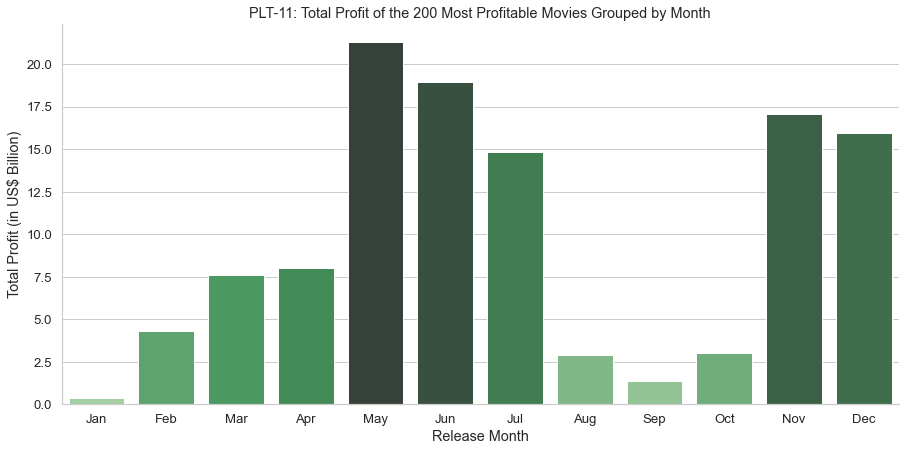

In [43]:
# Bar Plot - Total Profit by Month 
sns.set(style="whitegrid", 
        color_codes=True, 
        font_scale=1.2)
fig, ax = plt.subplots(figsize=(15, 7))
data = grouped_profit_by_month.profit
pal = sns.color_palette("Greens_d", len(data))
rank = data.argsort().argsort()
sns.barplot(x=grouped_profit_by_month.release_month, 
            y=data, 
            palette=np.array(pal)[rank])
ax.set(xlabel='Release Month', 
       ylabel='Total Profit (in US$ Billion)', 
       title='PLT-11: Total Profit of the 200 Most Profitable Movies Grouped by Month')

ax.yaxis.set_major_formatter(plticker.FuncFormatter(lambda x, pos: '{:,.1f}'.format(x/(10**9))))

sns.despine(bottom=False, left=False)
plt.show()

In terms of profit, summer months (May/June/July) seem to be the best time to release a movie for profit. The second best time of the year is around the Holiday seasons (November/December).

In [44]:
grouped_returns_by_month = top200returns.groupby('release_month', as_index=False).movie_title.count()
grouped_returns_by_month['month'] = grouped_returns_by_month.release_month.map(lambda x: month_dict[x.lower()])
grouped_returns_by_month.sort_values(by='month', inplace=True)

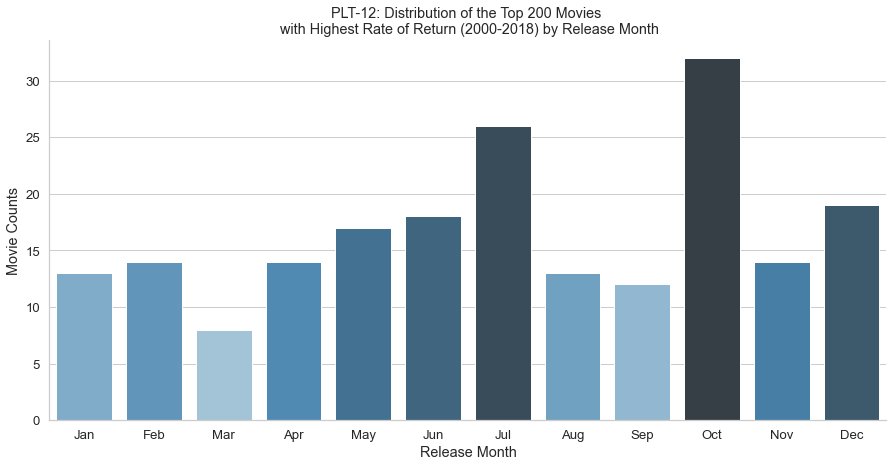

In [45]:
# Bar Plot - Top 200 movies with highest Rate of Return grouped by Month 
sns.set(style="whitegrid", 
        color_codes=True, 
        font_scale=1.2)
fig, ax = plt.subplots(figsize=(15, 7))
data = grouped_returns_by_month.movie_title
pal = sns.color_palette("Blues_d", len(data))
rank = data.argsort().argsort()
sns.barplot(x=grouped_profit_by_month.release_month, 
            y=data, 
            palette=np.array(pal)[rank])
ax.set(xlabel='Release Month', 
       ylabel='Movie Counts', 
       title='PLT-12: Distribution of the Top 200 Movies \n with Highest Rate of Return (2000-2018) by Release Month')
sns.despine(bottom=False, left=False)
plt.show();

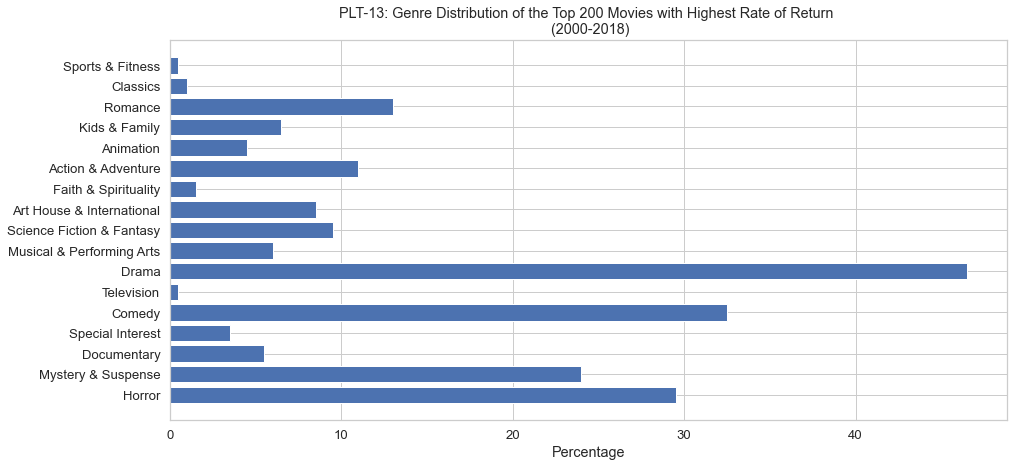

In [46]:
top200return_ls = [x.strip() for x in top200returns.genres.str.cat(sep=', ').split(',')]
freq = {}
for item in top200return_ls:
    freq[item] = top200return_ls.count(item) / 200 * 100
plt.figure(figsize=(15, 7))
plt.barh(list(freq.keys()), list(freq.values()))
plt.xlabel('Percentage')
plt.title('PLT-13: Genre Distribution of the Top 200 Movies with Highest Rate of Return \n (2000-2018)')
plt.show();

Genre distribution of the top 200 movies with highest rate of return shows that right after <b>Drama</b> and <b>Comedy</b> which are also the top 2 most popular genres in terms of movie percentages released between 2000 and 2018, <b>Horror</b> and <b>Mystery & Suspense</b> have climbed up to the 3rd and 4th spots and take up roughly 25-30% of these movies with high return. 

This finding corresponds with plot PLT-11, 'Distribution of the Top 200 Movies with Highest Rate of Return (2000-2018) by Release Month', which indicates that the best time to release a movie for high return on investment is October, the month of Halloween. 

#### 3. Directors
We will then identify the top 10 directors that have generated the most profits with their movies. Profit evaluation for these directors will be approached from 2 different angles:
- Total profit generated
- Average profit per movie

In [47]:
top10directors = tn_rotten_tomatoes.groupby('directors').profit.sum()\
                                   .sort_values(ascending=False)[:10]\
                                   .reset_index().set_index('directors')

In [48]:
director_avg_profit = tn_rotten_tomatoes.groupby('directors').profit.mean()\
                                        .reset_index().set_index('directors')
top10dirs = top10directors.merge(director_avg_profit,
                                 how='inner', 
                                 left_on='directors', right_on='directors',
                                 suffixes=('_total', '_avg'))

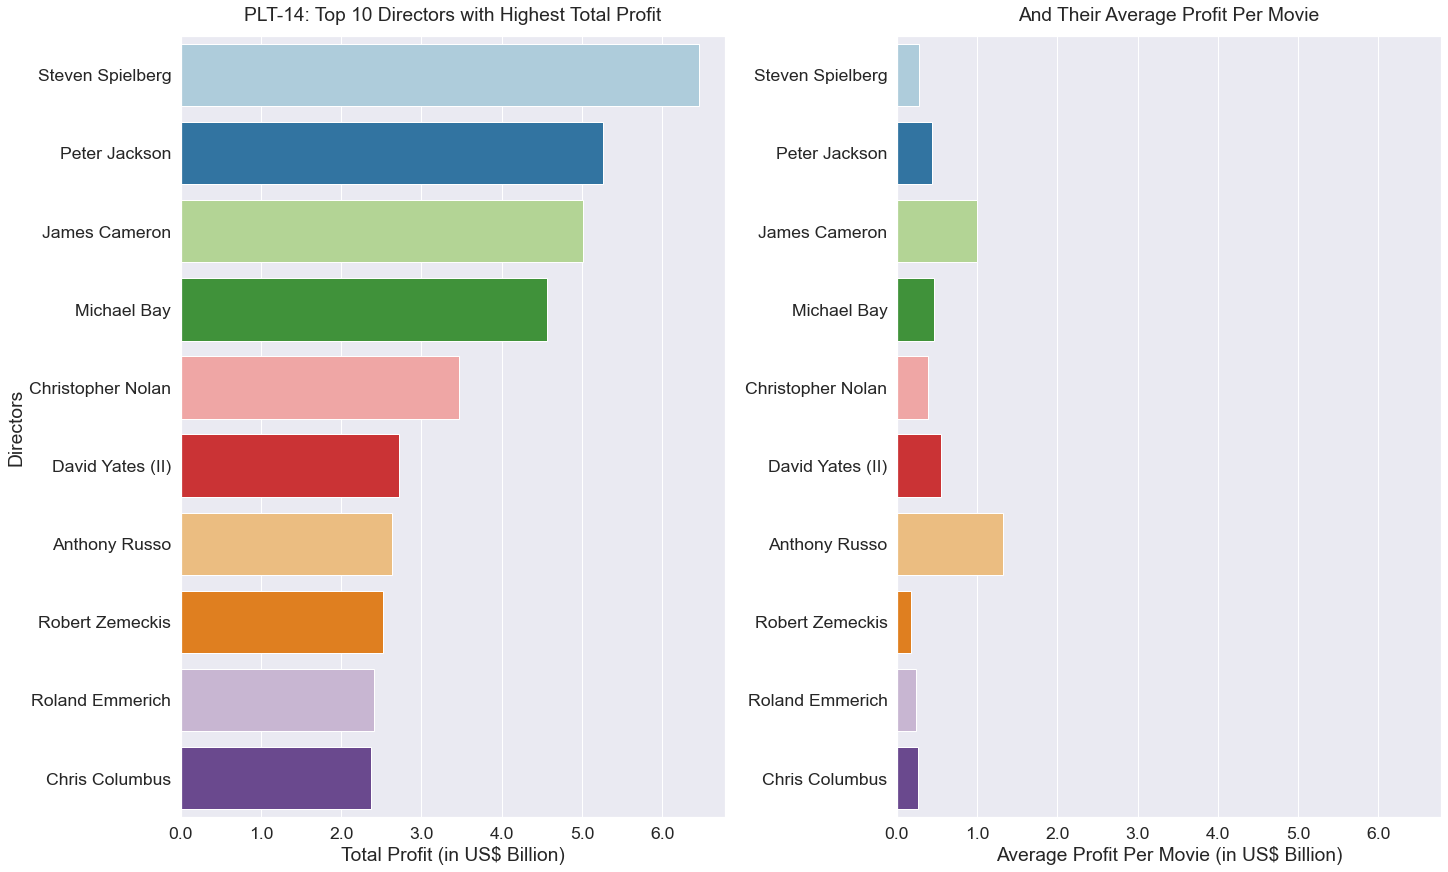

In [49]:
# Bar Plot - top 10 directors with total profit & average profit per movie
sns.set(style="darkgrid", font_scale=1.6)
sns.set_palette('Paired')
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, 
                               figsize=(20, 12), sharex=True,
                               constrained_layout=True)

sns.barplot(ax=ax1,
            x=top10dirs.profit_total, 
            y=top10dirs.index)
ax1.set(xlabel='Total Profit (in US$ Billion)', 
        ylabel='Directors')
ax1.set_title('PLT-14: Top 10 Directors with Highest Total Profit', pad=15)

sns.barplot(ax=ax2,
            x=top10dirs.profit_avg, 
            y=top10dirs.index)
ax2.set(xlabel='Average Profit Per Movie (in US$ Billion)')
ax2.set_ylabel('')  
ax2.set_title('And Their Average Profit Per Movie', pad=15)

ax1.xaxis.set_major_formatter(plticker.FuncFormatter(lambda x, pos: '{:,.1f}'.format(x/(10**9))))
ax2.xaxis.set_major_formatter(plticker.FuncFormatter(lambda x, pos: '{:,.1f}'.format(x/(10**9))))

plt.show();

Although <b>Steven Spielberg</b> has generated the most profit with his movies, <b>Anthony Russo</b> has the highest average profit per movie. <b>Russo</b> is known for <b>"Captain America: The Winter Soldier"</b> (2014), <b>"Avengers: Endgame"</b> (2019), and <b>"Avengers: Infinity War"</b> (2018).

#### 4. Production Studio
In order to gauge the market distribution among different production studios, we will evaluate the market based on 2 variables:
- Total worldwide box office grossing 
- Total number of movies produced

Our `tn_rotten_tomatoes` dataset contains 13 rows with `NaN` value identified for `production_company`. We will replace these Null values with the string `"NaN"`.

In [50]:
tn_rotten_tomatoes.production_company.isna().sum()

12

In [51]:
# Fill-in NaN values in the production_company column with string "NaN"
tn_rotten_tomatoes.production_company.fillna(value="NaN", inplace=True)

In [52]:
tn_rotten_tomatoes.production_company.isna().sum()

0

The 6 major conglogmerates studios in the movie production industry are <b>'Warner Bros'</b>, <b>'Walt Disney'</b>, <b>'20th Century Fox'</b>, <b>'Paramount'</b>, <b>'Sony'</b>, and <b>'Universal'</b>. We'll look at the market distribution in the last 20 years to see if there is any trend we can identify that can give an edge for a new production company to break into the market. 

Then we will add another column `major_studios` indicating whether a movie is produced by at least one of the 6 major studios or not

In [53]:
tn_rotten_tomatoes['major_studios'] = tn_rotten_tomatoes.production_company.apply(lambda x: 1 if helpers.if_major_studio(x) else 0)

In [54]:
# Selecting only movies released between 2000-2018
studio_movie_counts = tn_rotten_tomatoes.groupby([tn_rotten_tomatoes.release_date.dt.year, 'major_studios'])\
                                        .movie_title.nunique().reset_index()
studio_movie_counts_0018 = studio_movie_counts[~(studio_movie_counts.release_date < 2000)]

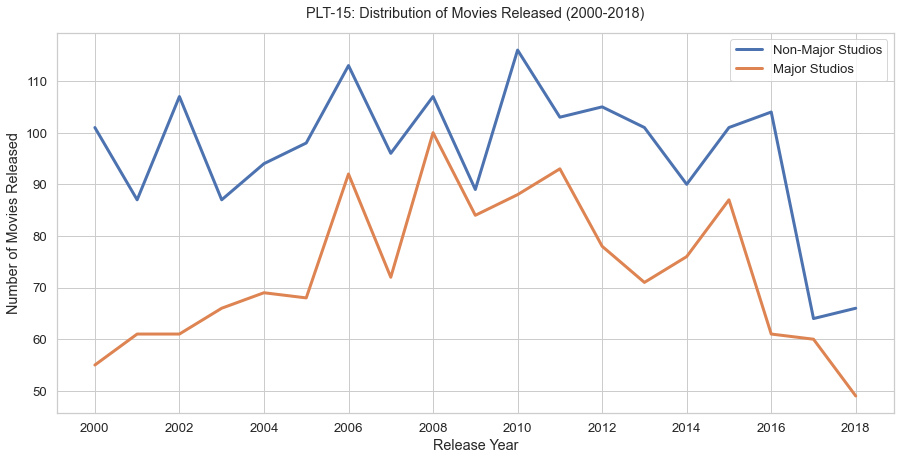

In [56]:
# Movie Released by Major Studios vs. Non-Major Studios from 2000 to 2019
# sns.set_palette('CMRmap_r')
sns.set(style='whitegrid', font_scale=1.2)
dt = studio_movie_counts_0018.set_index('release_date').pivot(columns='major_studios', values='movie_title')
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(dt, lw=3)
ax.set(xlabel = 'Release Year',
       ylabel = 'Number of Movies Released')
sns.color_palette("BrBG")
ax.set_title('PLT-15: Distribution of Movies Released (2000-2018)', pad=15)
ax.xaxis.set_major_locator(plticker.MultipleLocator(2))
plt.legend(['Non-Major Studios', 'Major Studios'])
# plt.legend()
plt.show();

#### 4. Ratings vs. Commercial Success
Lastly, we will investigate the relation between Ratings (by both professional critics and public audience) and Commercial Success (`worldwide_gross`). We'll add another dimension to the analysis by taking into consideration whether the production company is one of the 6 major studios (`major_studios`).

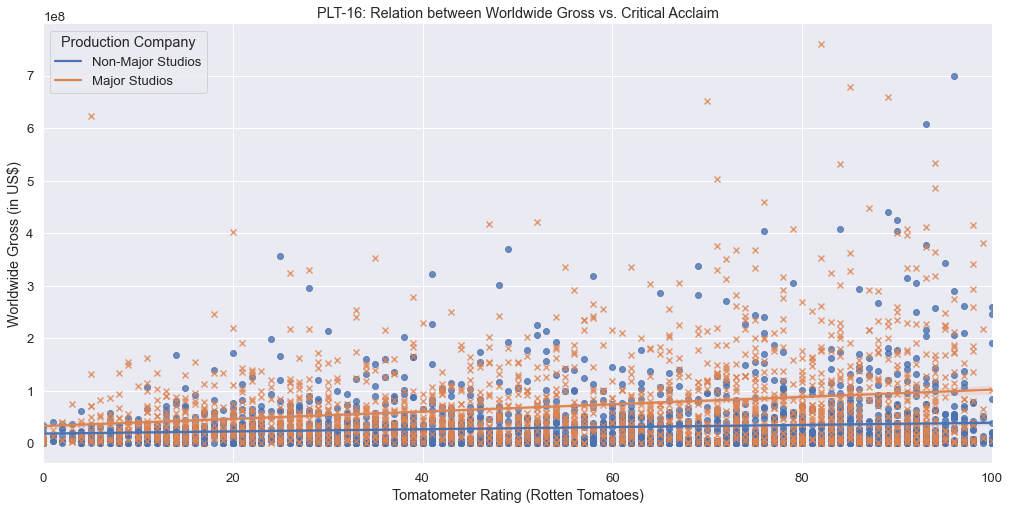

In [57]:
# Relation between Worldwide Gross vs. Critical Acclaim
sns.set(style="darkgrid", 
        color_codes=True, 
        font_scale=1.2)
g = sns.lmplot(x="tomatometer_rating", y="domestic_gross", 
           data=tn_rotten_tomatoes,
           hue='major_studios',
           markers=["o", "x"],
           legend_out=False,
           height=7, aspect=2)

g.set(ylabel='Worldwide Gross (in US$)', 
        xlabel='Tomatometer Rating (Rotten Tomatoes)', 
        title='PLT-16: Relation between Worldwide Gross vs. Critical Acclaim')

plt.legend(title='Production Company', loc='upper left', labels=['Non-Major Studios', 'Major Studios'])
plt.show();

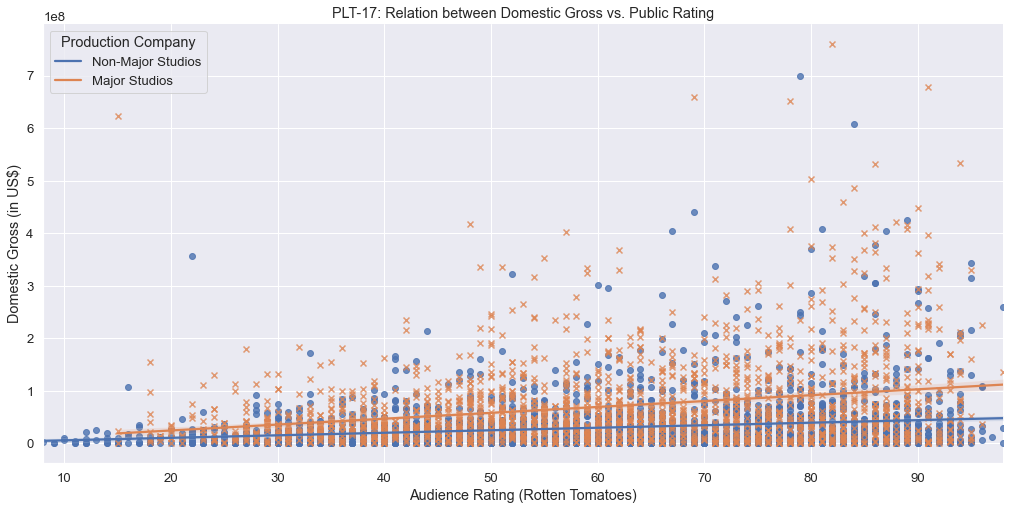

In [58]:
# Relation between Worldwide Gross vs. Public Rating
sns.set(style="darkgrid", 
        color_codes=True, 
        font_scale=1.2)
g = sns.lmplot(x="audience_rating", y="domestic_gross", 
           data=tn_rotten_tomatoes,
           hue='major_studios',
           markers=["o", "x"],
           legend_out=False,
           height=7, aspect=2)

g.set(ylabel='Domestic Gross (in US$)', 
        xlabel='Audience Rating (Rotten Tomatoes)', 
        title='PLT-17: Relation between Domestic Gross vs. Public Rating')

plt.legend(title='Production Company', loc='upper left', labels=['Non-Major Studios', 'Major Studios'])
plt.show();

In both plots (PLT-16 and PLT-17), the correlation between Ratings and Worldwide Gross is relatively low, with that of movies produced by 6 major studios being slightly higher. 

## Evaluation
Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

## Conclusions

Some findings that could be beneficial for a new production company prior to entering the filmmaking industry can be derived from this exploratory analysis as follows:
<br>
- Combining different genres generally boosts profit and return on investment as it helps attract more demographics. Some of the most profitable combinations include <b>Action & Adventure</b>, <b>Science Fiction & Fantasy</b> with some elements of <b>Drama</b>, <b>Comedy</b> and <b>Mystery & Suspense</b>. However, producing movies based too directly on past success could also lead to potentially over-saturating the market. Therefore, it is always important to incorporate elements of novelty into the movies and take into consideration how the audience might have evolved over time.  


- <b>May</b> and <b>June</b> are the best months to release a movie for potential profit. The best time to release a <b>Horror</b> and <b>Mystery & Suspense</b> movie would be <b>October</b>. Some of the movies with highest rate of return (profit/budget) in the last 20 years are categorized as <b>Horror</b> and <b>Mystery & Suspense</b>.  


- Top candidates to assume the role <b>directors</b> would be <b>Anthony Russo</b> and <b>James Cameron</b>.

## Next Steps

The landscape of the movie production and consumption has changed dramatically since the introduction of media streaming services in 2007; and it would require a more technological approach to navigate moving forward. The traditional assessment of a movie’s commercial success based mainly on its box office is no longer sufficient. Further analyses on some of the following attributes and features relations could potentially yield more relevant insights to how to optimize a new production company’s entry into the market:

- How the trends for different genres might be correlated
- Number of views of a movie on various streaming platforms, and an estimated revenue coming from these sources
- How frequently a movie is mentioned/hashtagged on various social media platforms (Facebook, Twitter, Instagram)
- Records of the Awards/Recognitions for each movie if any
- Number of awards/recognitions that the movie’s crew have earned prior to the release of that movie
- Records of economical/cultural events that might have altered the relevancy of a movie’s subject matter in a short period of time
- Whether the movie is part of a sequel, adaptations (comics, best-selling books)

On another note, the movie market has been different due to COVID-19. Lockdowns, quarantines, and the closure of movie theaters across the country might lead to higher demand for movie tickets when it is allowed to open again. Datapoints for the movie production and consumption for 2020 and the few years after that which can help provide valuable insights into the impact of a major disaster and/or catastrophic event on this specific industry, and how to navigate such event for future references.